## Importing modules

In [1]:
#Importing modules and font style
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import zika_postprocess as zp
%matplotlib inline
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16
plt.rcParams['lines.linewidth']=3
plt.rcParams['lines.markersize']=10

## Molar to debye length to kappa

In [2]:
# --> mM [2,5,10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200] 22

# --> Debye length (nm) [6.888204173817549, 4.356482835508365, 3.0804985551107635, 2.1782414177541827,1.7785266700314526,1.5402492775553818,1.3776408347635098,1.2576082689003694,1.1643190129881256
# , 1.0891207088770913,1.0268328517035876, 0.9741391763007738,  0.9288052613213044, 0.8892633350157263, 0.8543765764957377, 0.8232978695483315, 0.7953813067973331, 0.7701246387776909,
# 0.7471306424873098, 0.7260804725847274, 0.706714836707941, 0.6888204173817549]

# --> Kappa (1/nm) 	

# array([0.01451757, 0.0229543 , 0.03246228, 0.04590859, 0.05622631,
#        0.06492456, 0.07258786, 0.07951602, 0.08588711, 0.09181719,
#        0.09738683, 0.10265474, 0.1076652 , 0.11245263, 0.11704441,
#        0.12146272, 0.12572586, 0.12984911, 0.1338454 , 0.13772578,
#        0.14149979, 0.14517572])

molar_data = [2,5,10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200] 

kappa = np.array([0.01451757, 0.0229543 , 0.03246228, 0.04590859, 
        0.05622631, 0.06492456, 0.07258786, 0.07951602, 0.08588711, 
        0.09181719, 0.09738683, 0.10265474, 0.1076652 , 0.11245263, 
        0.11704441, 0.12146272, 0.12572586, 0.12984911, 0.1338454 , 
        0.13772578, 0.14149979, 0.14517572])

molar_to_kappa = dict(zip(molar_data, kappa))


## Read data from dir 

In [3]:
data_sim,data_sim1,data_sim2,data_sim3,data_sim_127_560, data_sim_128_560 = zp.get_data_sym(sym=0), zp.get_data_sym(sym=1), \
    zp.get_data_sym(sym=2), zp.get_data_sym(sym=3),zp.get_data_sym(folder='ZikaSym127_560'),zp.get_data_sym(folder='ZikaSym128_560')

## Plot example

### Load simulation files

In [4]:
molar = '40'

dist,fqf,_ = zp.compute_force_qf_zika(data_sim[molar], units='pN',fqf_calc=False)
fdb, fib = zp.get_boundary_forces(data_sim, molar)

# Binding force by substracting solvation force for capsid far away from tip
F_terms = fqf+fdb+fib - (fqf[-1]+fdb[-1]+fib[-1] )


### Plot Capsid-Sphere molaridad $= 40 mM$ 

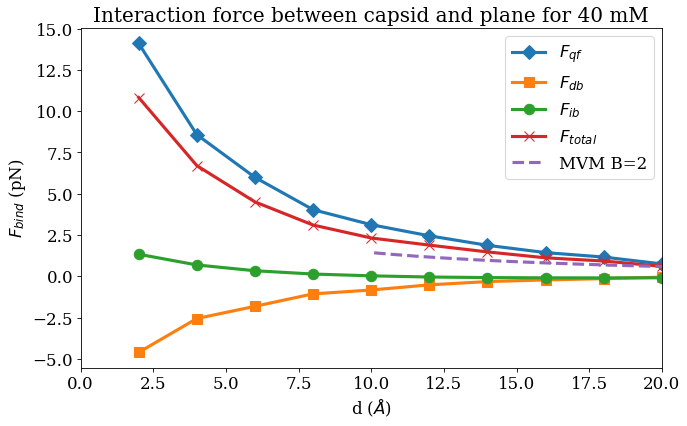

In [5]:
delta_fqf = (fqf.swapaxes(0,1)[0]-fqf.swapaxes(0,1)[0][-1])
delta_fdb = (fdb.swapaxes(0,1)[0]-fdb.swapaxes(0,1)[0][-1])
delta_fib = (fib.swapaxes(0,1)[0]-fib.swapaxes(0,1)[0][-1])
dd = np.arange(394,434,0.1)

plt.figure(figsize=(10,6),dpi=75)
plt.grid()
plt.plot(dist,-delta_fqf, marker='D',label='$F_{qf}$')
plt.plot(dist,-delta_fdb, marker='s',label='$F_{db}$')
plt.plot(dist,-delta_fib, marker='o',label='$F_{ib}$')
plt.plot(dist,-F_terms.swapaxes(0,1)[0], marker='x',label='$F_{total}$')
plt.plot(dd[1:]-384,zp.forces_MVM(dd[1:]-384,2,k=molar_to_kappa[int(molar)]),label='MVM B=2',linestyle='--')
plt.grid()
plt.xlim([0,20])
plt.xlabel('d ($\AA$)');
plt.ylabel('$F_{bind}$ (pN)')
plt.legend()
plt.title('Interaction force between capsid and plane for %d mM' % int(molar))
plt.savefig('plots\\interaction_force_afmtip_%d(mM).png' % int(molar),dpi=150, bbox_inches='tight')
plt.show()
plt.close()


## Plot several molar values code

### Base

In [7]:
# Plotting al molar values detected in results folder
for molar in molar_data:
    if int(molar) not in [160]:
        print('printing interaction force for %d mM' % int(molar))
        zp.plot_force_components(data_sim,str(molar),sym=0,fqf_calc=False)

printing interaction force for 2 mM
printing interaction force for 5 mM
printing interaction force for 10 mM
printing interaction force for 20 mM
printing interaction force for 30 mM
printing interaction force for 40 mM
printing interaction force for 50 mM
printing interaction force for 60 mM
printing interaction force for 70 mM
printing interaction force for 80 mM
printing interaction force for 90 mM
printing interaction force for 100 mM
printing interaction force for 110 mM
printing interaction force for 120 mM
printing interaction force for 130 mM
printing interaction force for 140 mM
printing interaction force for 150 mM
printing interaction force for 170 mM
printing interaction force for 180 mM
printing interaction force for 190 mM
printing interaction force for 200 mM


### Sym 1

In [8]:
# Plotting al molar values detected in results folder
for molar in molar_data:
    print('printing interaction force for %d mM' % int(molar))
    zp.plot_force_components(data_sim1,str(molar),sym=1,fqf_calc=False)

printing interaction force for 2 mM
printing interaction force for 5 mM
printing interaction force for 10 mM
printing interaction force for 20 mM
printing interaction force for 30 mM
printing interaction force for 40 mM
printing interaction force for 50 mM
printing interaction force for 60 mM
printing interaction force for 70 mM
printing interaction force for 80 mM
printing interaction force for 90 mM
printing interaction force for 100 mM
printing interaction force for 110 mM
printing interaction force for 120 mM
printing interaction force for 130 mM
printing interaction force for 140 mM
printing interaction force for 150 mM
printing interaction force for 160 mM
printing interaction force for 170 mM
printing interaction force for 180 mM
printing interaction force for 190 mM
printing interaction force for 200 mM


### Sym 2

In [4]:
for molar in molar_data:
    print('printing interaction force for %d mM' % int(molar))
    zp.plot_force_components(data_sim2,str(molar),sym=2,fqf_calc=False)

printing interaction force for 2 mM
printing interaction force for 5 mM
printing interaction force for 10 mM
printing interaction force for 20 mM
printing interaction force for 30 mM
printing interaction force for 40 mM
printing interaction force for 50 mM
printing interaction force for 60 mM
printing interaction force for 70 mM
printing interaction force for 80 mM
printing interaction force for 90 mM
printing interaction force for 100 mM
printing interaction force for 110 mM
printing interaction force for 120 mM
printing interaction force for 130 mM
printing interaction force for 140 mM
printing interaction force for 150 mM
printing interaction force for 160 mM
printing interaction force for 170 mM
printing interaction force for 180 mM
printing interaction force for 190 mM
printing interaction force for 200 mM


### Sym3

In [5]:
for molar in molar_data[2:]:
    print('printing interaction force for %d mM' % int(molar))
    zp.plot_force_components(data_sim3,str(molar),sym=3,fqf_calc=False)

printing interaction force for 10 mM
printing interaction force for 20 mM
printing interaction force for 30 mM
printing interaction force for 40 mM
printing interaction force for 50 mM
printing interaction force for 60 mM
printing interaction force for 70 mM
printing interaction force for 80 mM
printing interaction force for 90 mM
printing interaction force for 100 mM
printing interaction force for 110 mM
printing interaction force for 120 mM
printing interaction force for 130 mM
printing interaction force for 140 mM
printing interaction force for 150 mM
printing interaction force for 160 mM
printing interaction force for 170 mM
printing interaction force for 180 mM
printing interaction force for 190 mM
printing interaction force for 200 mM


## Plot forces by distance and molarity (3d-plot)

### Base

In [4]:
## Base
delta_fqf_base,delta_fdb_base,delta_fib_base, F_bindx_base = dict(), dict(), dict(), dict()

for molar in molar_data[:]:
    if molar in [160]:
        continue
    molar = str(molar)
    print('calculating interaction force for %d mM' % int(molar))

    dist,fqf,_ = zp.compute_force_qf_zika(data_sim[molar], units='pN', fqf_calc=False)
    fdb, fib = zp.get_boundary_forces(data_sim, molar)

    # Binding force by substracting solvation force for capsid far away from tip
    F_terms = fqf+fdb+fib - (fqf[-1]+fdb[-1]+fib[-1] )

    delta_fqf = (fqf.swapaxes(0,1)[0]-fqf.swapaxes(0,1)[0][-1])
    delta_fdb = (fdb.swapaxes(0,1)[0]-fdb.swapaxes(0,1)[0][-1])
    delta_fib = (fib.swapaxes(0,1)[0]-fib.swapaxes(0,1)[0][-1])
    F_bindx = F_terms.swapaxes(0,1)[0]

    delta_fqf_base[molar] = delta_fqf
    delta_fdb_base[molar] = delta_fdb
    delta_fib_base[molar] = delta_fib
    F_bindx_base[molar] = F_bindx

calculating interaction force for 2 mM
calculating interaction force for 5 mM
calculating interaction force for 10 mM
calculating interaction force for 20 mM
calculating interaction force for 30 mM
calculating interaction force for 40 mM
calculating interaction force for 50 mM
calculating interaction force for 60 mM
calculating interaction force for 70 mM
calculating interaction force for 80 mM
calculating interaction force for 90 mM
calculating interaction force for 100 mM
calculating interaction force for 110 mM
calculating interaction force for 120 mM
calculating interaction force for 130 mM
calculating interaction force for 140 mM
calculating interaction force for 150 mM
calculating interaction force for 170 mM
calculating interaction force for 180 mM
calculating interaction force for 190 mM
calculating interaction force for 200 mM


### Sym1

In [5]:
# Sym1
delta_fqf_sym1,delta_fdb_sym1,delta_fib_sym1, F_bindx_sym1 = dict(), dict(), dict(), dict()

for molar in molar_data[:]:
    # if int(molar) in [160]:
    #     continue 
    molar = str(molar)
    print('calculating interaction force for %d mM' % int(molar))

    dist,fqf,_ = zp.compute_force_qf_zika(data_sim1[molar], units='pN', fqf_calc=False)
    fdb, fib = zp.get_boundary_forces(data_sim1, molar)

    # Binding force by substracting solvation force for capsid far away from tip
    F_terms = fqf+fdb+fib - (fqf[-1]+fdb[-1]+fib[-1] )

    delta_fqf = (fqf.swapaxes(0,1)[0]-fqf.swapaxes(0,1)[0][-1])
    delta_fdb = (fdb.swapaxes(0,1)[0]-fdb.swapaxes(0,1)[0][-1])
    delta_fib = (fib.swapaxes(0,1)[0]-fib.swapaxes(0,1)[0][-1])
    F_bindx = F_terms.swapaxes(0,1)[0]

    delta_fqf_sym1[molar] = delta_fqf
    delta_fdb_sym1[molar] = delta_fdb
    delta_fib_sym1[molar] = delta_fib
    F_bindx_sym1[molar] = F_bindx

calculating interaction force for 2 mM
calculating interaction force for 5 mM
calculating interaction force for 10 mM
calculating interaction force for 20 mM
calculating interaction force for 30 mM
calculating interaction force for 40 mM
calculating interaction force for 50 mM
calculating interaction force for 60 mM
calculating interaction force for 70 mM
calculating interaction force for 80 mM
calculating interaction force for 90 mM
calculating interaction force for 100 mM
calculating interaction force for 110 mM
calculating interaction force for 120 mM
calculating interaction force for 130 mM
calculating interaction force for 140 mM
calculating interaction force for 150 mM
calculating interaction force for 160 mM
calculating interaction force for 170 mM
calculating interaction force for 180 mM
calculating interaction force for 190 mM
calculating interaction force for 200 mM


### Sym2

In [10]:
# Sym2
delta_fqf_sym2,delta_fdb_sym2,delta_fib_sym2, F_bindx_sym2 = dict(), dict(), dict(), dict()

for molar in molar_data:
    # if int(molar) in [160]:
    #     continue 
    molar = str(molar)
    print('calculating interaction force for %d mM' % int(molar))

    dist,fqf,_ = zp.compute_force_qf_zika(data_sim2[molar], units='pN', fqf_calc=False)
    fdb, fib = zp.get_boundary_forces(data_sim2, molar)

    # Binding force by substracting solvation force for capsid far away from tip
    F_terms = fqf+fdb+fib - (fqf[-1]+fdb[-1]+fib[-1] )

    delta_fqf = (fqf.swapaxes(0,1)[0]-fqf.swapaxes(0,1)[0][-1])
    delta_fdb = (fdb.swapaxes(0,1)[0]-fdb.swapaxes(0,1)[0][-1])
    delta_fib = (fib.swapaxes(0,1)[0]-fib.swapaxes(0,1)[0][-1])
    F_bindx = F_terms.swapaxes(0,1)[0]

    delta_fqf_sym2[molar] = delta_fqf
    delta_fdb_sym2[molar] = delta_fdb
    delta_fib_sym2[molar] = delta_fib
    F_bindx_sym2[molar] = F_bindx

calculating interaction force for 2 mM
calculating interaction force for 5 mM
calculating interaction force for 10 mM
calculating interaction force for 20 mM
calculating interaction force for 30 mM
calculating interaction force for 40 mM
calculating interaction force for 50 mM
calculating interaction force for 60 mM
calculating interaction force for 70 mM
calculating interaction force for 80 mM
calculating interaction force for 90 mM
calculating interaction force for 100 mM
calculating interaction force for 110 mM
calculating interaction force for 120 mM
calculating interaction force for 130 mM
calculating interaction force for 140 mM
calculating interaction force for 150 mM
calculating interaction force for 160 mM
calculating interaction force for 170 mM
calculating interaction force for 180 mM
calculating interaction force for 190 mM
calculating interaction force for 200 mM


### Sym3

In [11]:
# Sym3
delta_fqf_sym3,delta_fdb_sym3,delta_fib_sym3, F_bindx_sym3 = dict(), dict(), dict(), dict()

for molar in molar_data:
    # if molar in [160]:
    #     continue
    molar = str(molar)
    print('calculating interaction force for %d mM' % int(molar))

    dist,fqf,_ = zp.compute_force_qf_zika(data_sim3[molar], units='pN', fqf_calc=False)
    fdb, fib = zp.get_boundary_forces(data_sim3, molar)

    # Binding force by substracting solvation force for capsid far away from tip
    F_terms = fqf+fdb+fib - (fqf[-1]+fdb[-1]+fib[-1] )

    delta_fqf = (fqf.swapaxes(0,1)[0]-fqf.swapaxes(0,1)[0][-1])
    delta_fdb = (fdb.swapaxes(0,1)[0]-fdb.swapaxes(0,1)[0][-1])
    delta_fib = (fib.swapaxes(0,1)[0]-fib.swapaxes(0,1)[0][-1])
    F_bindx = F_terms.swapaxes(0,1)[0]

    delta_fqf_sym3[molar] = delta_fqf
    delta_fdb_sym3[molar] = delta_fdb
    delta_fib_sym3[molar] = delta_fib
    F_bindx_sym3[molar] = F_bindx
    


calculating interaction force for 2 mM
calculating interaction force for 5 mM
calculating interaction force for 10 mM
calculating interaction force for 20 mM
calculating interaction force for 30 mM
calculating interaction force for 40 mM
calculating interaction force for 50 mM
calculating interaction force for 60 mM
calculating interaction force for 70 mM
calculating interaction force for 80 mM
calculating interaction force for 90 mM
calculating interaction force for 100 mM
calculating interaction force for 110 mM
calculating interaction force for 120 mM
calculating interaction force for 130 mM
calculating interaction force for 140 mM
calculating interaction force for 150 mM
calculating interaction force for 160 mM
calculating interaction force for 170 mM
calculating interaction force for 180 mM
calculating interaction force for 190 mM
calculating interaction force for 200 mM


## Plot 3d

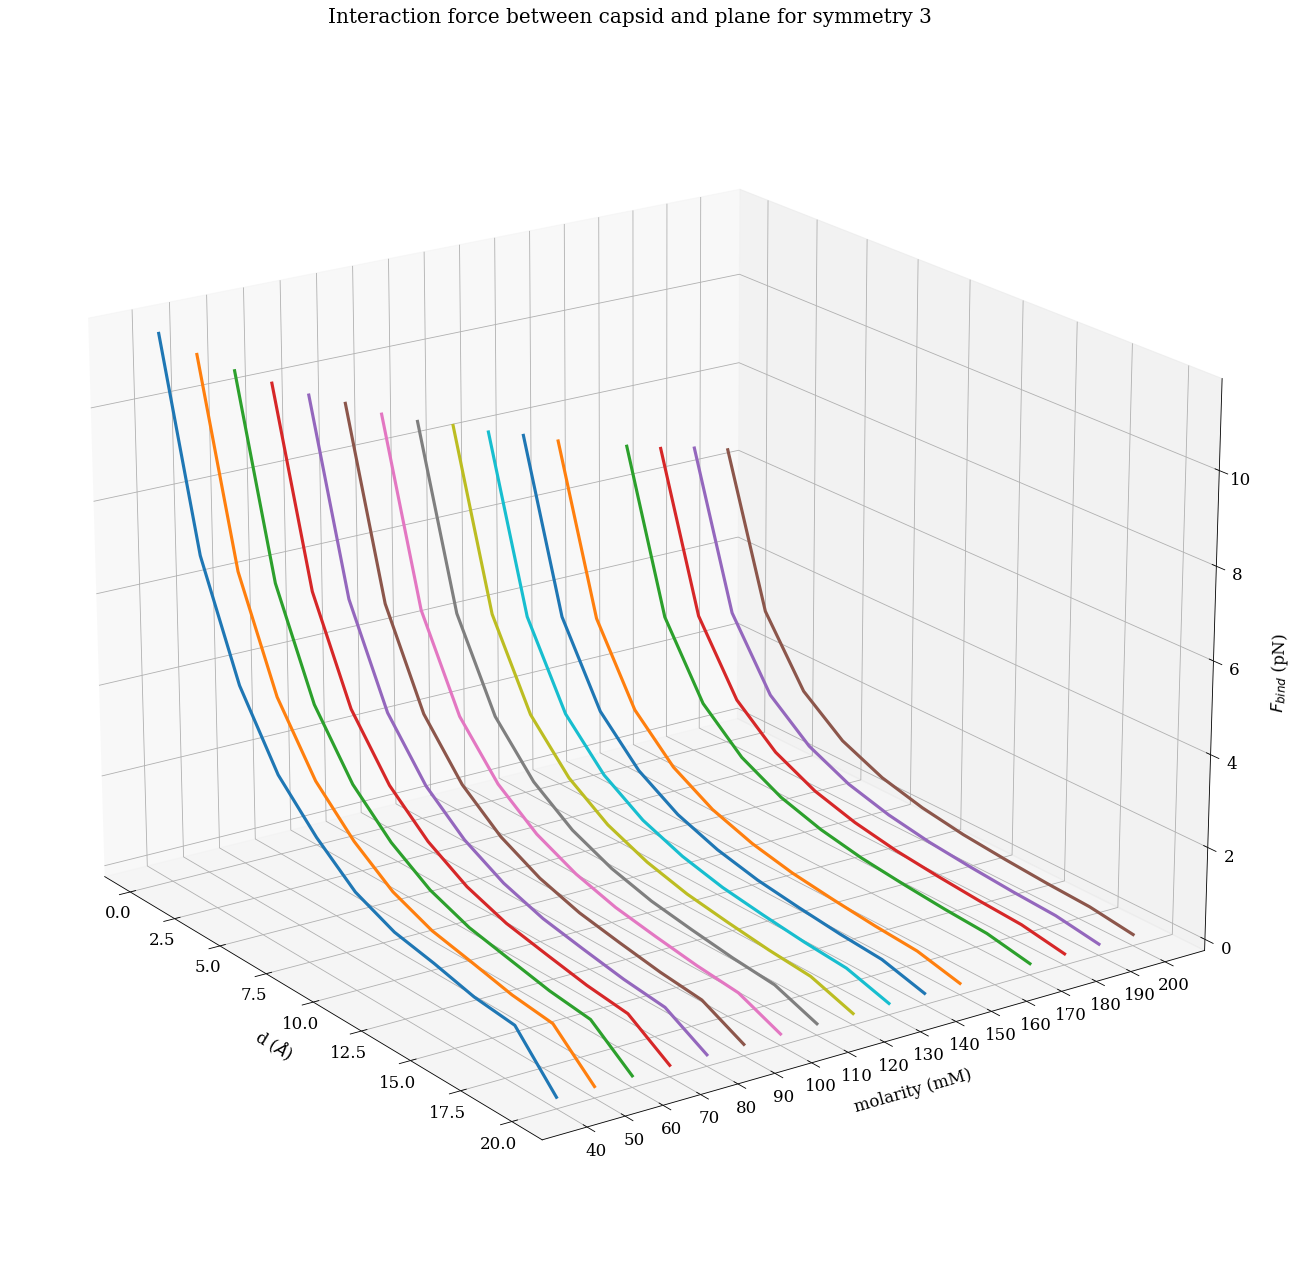

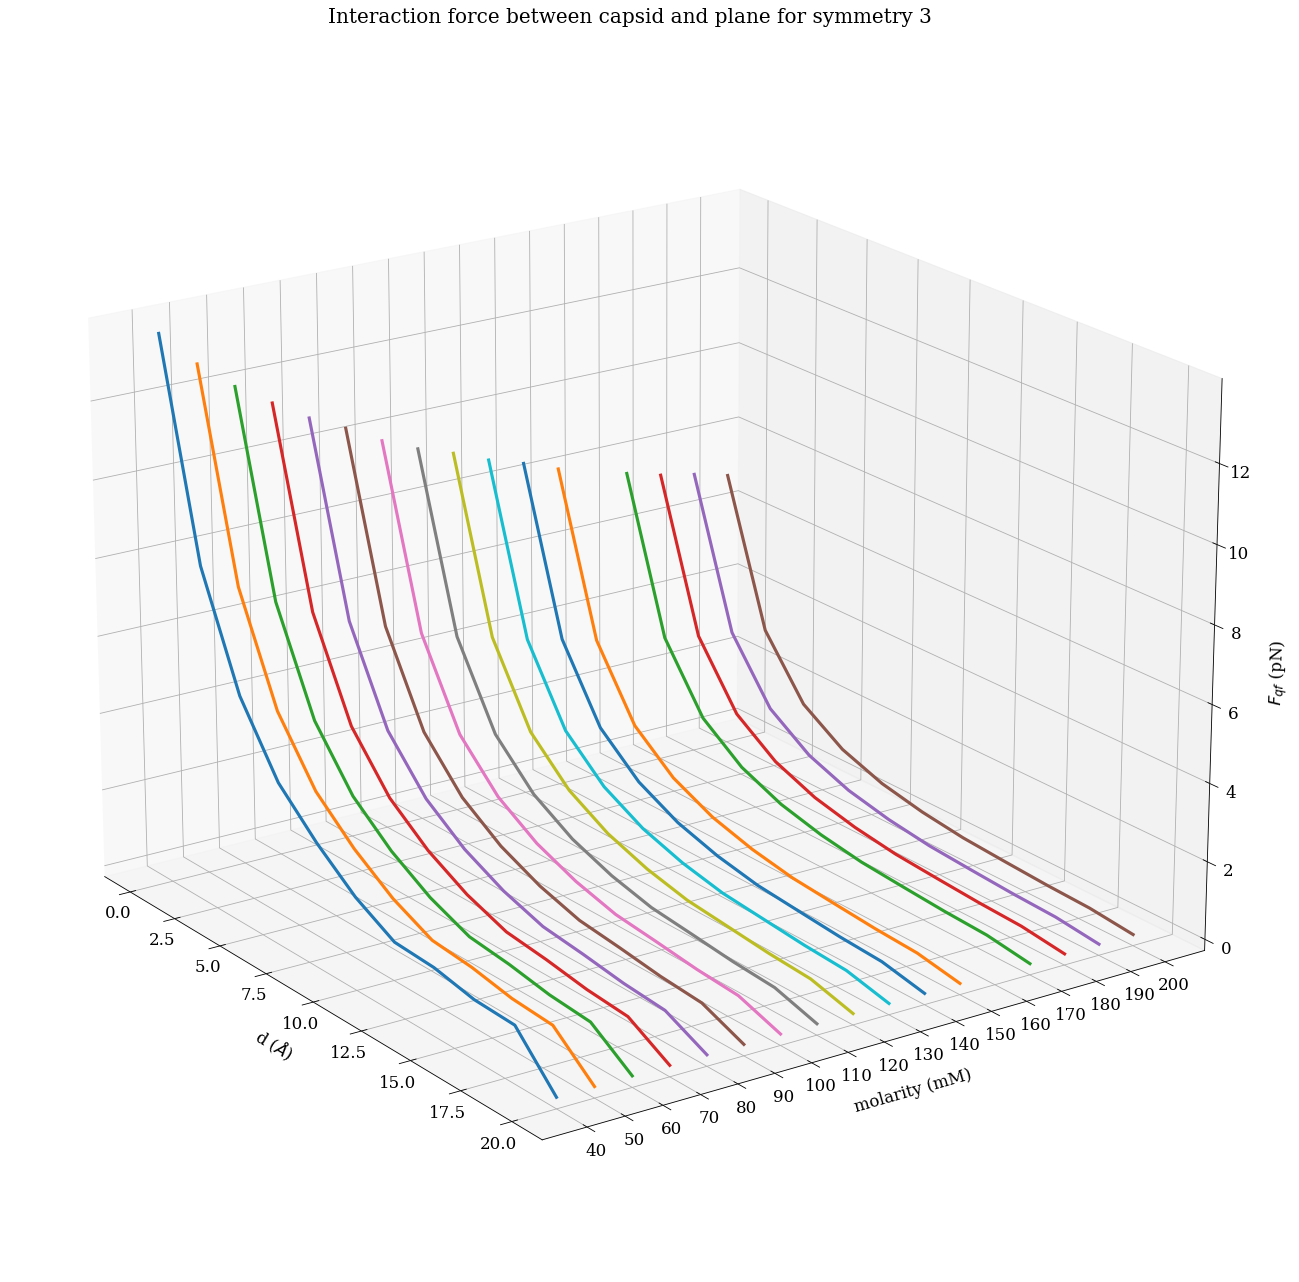

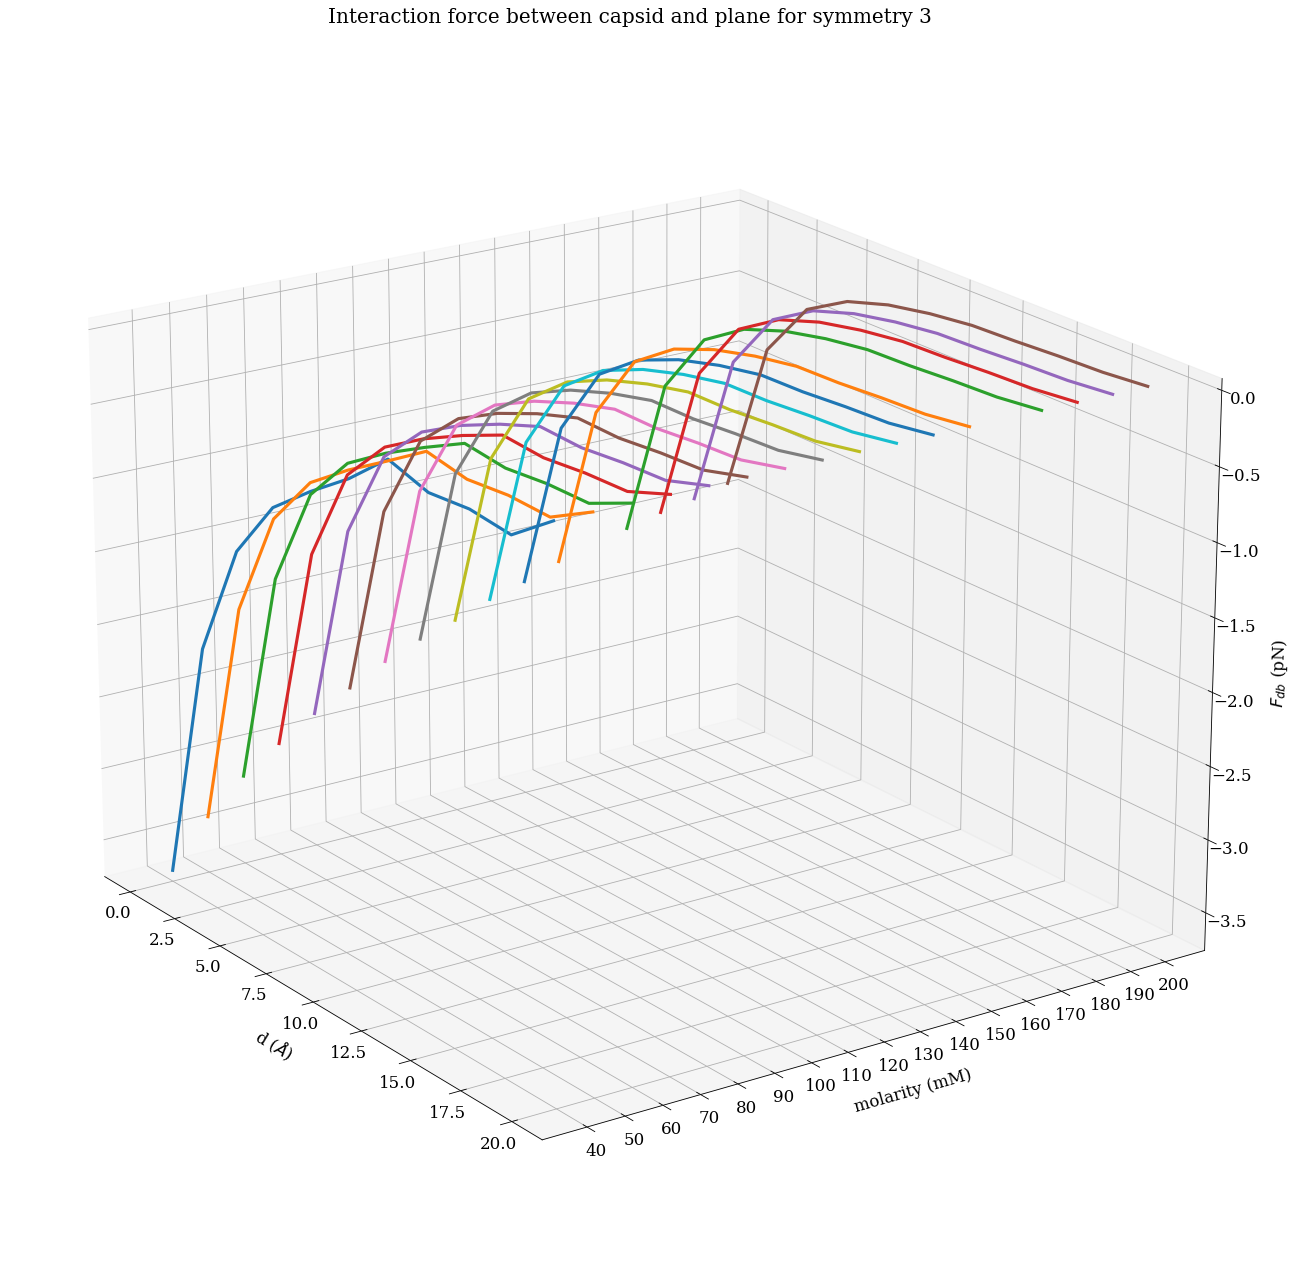

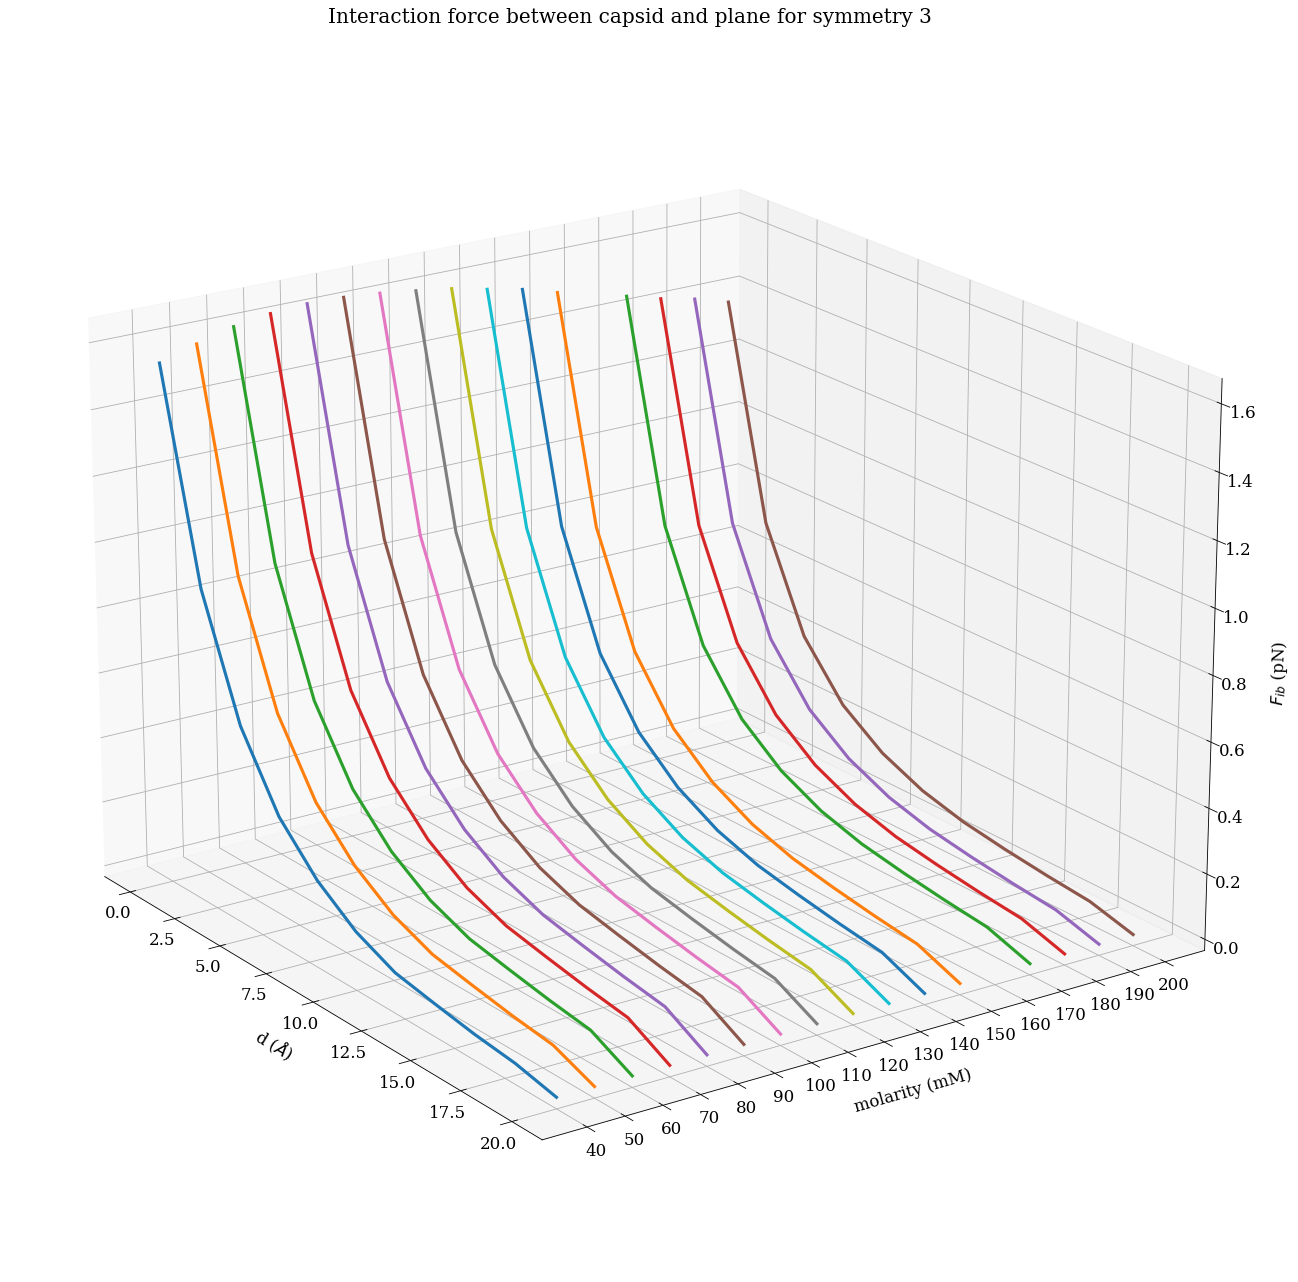

In [12]:
zp.plot_3d_lines(F_bindx_sym3, term='bind',sym=3,ratio=False,ratio_term=F_bindx_base)
zp.plot_3d_lines(delta_fqf_sym3, term='qf',sym=3,ratio=False,ratio_term=delta_fqf_base)
zp.plot_3d_lines(delta_fdb_sym3, term='db',sym=3,ratio=False,ratio_term=delta_fdb_base)
zp.plot_3d_lines(delta_fib_sym3, term='ib',sym=3,ratio=False,ratio_term=delta_fib_base)